In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from scipy.optimize import curve_fit

In [2]:
particles = {
    '-6': '4-HELIUM',
    '-5': '3-HELIUM',
    '-4': 'TRITON',
    '-3': 'DEUTERON',
    '-2': 'HEAVYION',
    '1' : 'PROTON'  ,
    '2' : 'HEAVYION', 
    '3' : 'ELECTRON',
    '4' : 'POSITRON',
    '5' : 'NEUTRIE',
    '6' : 'ANEUTRIE',
    '7' : 'PHOTON',
    '8' : 'NEUTRON',
    '9' : 'ANEUTRON',
    '10': 'MUON+',
    '11': 'MUON-',
    '12': 'KAONLONG',
    '13': 'PION+',
    '14': 'PION-',
    '15': 'KAON+',
    '16': 'KAON-', 
    '17': 'LAMBDA',
    '18': 'ALAMBDA',
    '19': 'KAONSHORT',
    '20': 'SIGMA-',
    '21': 'SIGMA+',
    '22': 'SIGMAZER',
    '23': 'PIZERO',
    '24': 'KAONZERO',
    '25': 'AKAONZER',
    '31': 'ASIGMA-',
    '32': 'ASIGMAZE',
    '33': 'ASIGMA+',
    '34': 'XSIZERO',    
    '35': 'AXSIZERO',
    '36': 'XSI-',
    '37': 'AXSI+',
    '38': 'OMEGA-',
    '39': 'AOMEGA-'
    
}

mass = {
    'PIZERO': 135.0,
    'PION+' : 139.6,
    'PION-' : 139.6,
    'PROTON': 938.3,
    'KAONZERO' : 497.6,
    'AKAONZER' : 497.6,
    'KAON+'    : 493.7,
    'KAON-'    : 493.7,
    'KAONSHORT': 497.6,
    'KAONLONG' : 497.6
    
}

In [3]:
def TotMomentum(px, py,pz):
    p = (px **2 + py **2 + pz**2 )**0.5
    return(p)

def Angle(pdir, ptot, px): #pdid is momentum in direction of beam (ie z)
    theta = np.arccos(pdir/ptot)
    if px > 0: #Give directionality to the angle using x arbitrarily
        return(theta)
    else:
        return(-theta)
    
def Gauss(x, a, x0, mu): #Define gaussian for fit
    return a*np.exp(-(x-x0)**2/(2*mu))

In [4]:
def PlottableData(eventList, particleInterested, nominalMomentum, massDict = mass, acceptance = 0.1): #from the list of events 
                                      #returns the angle. For the masses in calculation defaults to dictionary defined above
    direction = list()
    
    for item in eventList:
        
        if item[0] == particleInterested: 
            
            pTot = TotMomentum(*item[2])
            #eneries from data in GeV but mass in MeV, so converted when used
            #eventEnergy = (pTot ** 2 + (mass[particleInterested] * 10 **-3)** 2) **0.5 
            #remove particles if momentum spread too large
            if abs(pTot-nominalMomentum)/nominalMomentum <= acceptance: 
                direction.append(Angle(item[2][2], pTot, item[2][0]))
    return(direction)

In [14]:
material = "beryllium"
material = material.upper()
length = 51
energy = 400

particleList = ['pion+', 'pion-', 'kaon+', 'kaon-', 'proton']
for i in range(0, len(particleList)): #make all elements of list uppercase
    particleList[i] = particleList[i].upper()


nominalEnergyList = [2, 4, 6]
nominalMomentumList = [2, 4, 6]

path = r'C:\Users\mussolini\Desktop\PhD general\Impinging'
folderName = material + "_" + str(length) + "cm_" + str(energy) + "GeV"

fullpath = os.path.join(path, folderName)

file = fullpath + r"/input_0.dat" 

In [15]:
eventList = list() #list of type, position list, momentum list for each particle

with open(file, mode = 'r') as infile:
    reader = csv.reader(infile)
    for i, line in enumerate(reader):

        pclePos = []
        pcleMmt = []
        
        particleType = particles[line[0].split()[1]] #save particle id
        
        pclePos.append(float(line[0].split()[2])) #save psition in x
        pclePos.append(float(line[0].split()[3])) #y
        pclePos.append(float(line[0].split()[4])) #z
        
        pcleMmt.append(float(line[0].split()[5])) #save momentum in x 
        pcleMmt.append(float(line[0].split()[6])) #y
        pcleMmt.append(float(line[0].split()[7])) #z
        
        eventList.append([particleType, pclePos, pcleMmt])

Standard deviation of: 1.61E-01 rads at 2.0 GeV/c
Standard deviation of: 7.87E-02 rads at 4.0 GeV/c
Standard deviation of: 5.85E-02 rads at 6.0 GeV/c


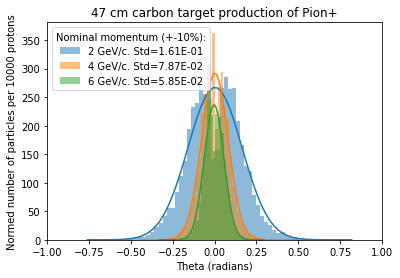

Standard deviation of: 1.54E-01 rads at 2.0 GeV/c
Standard deviation of: 7.98E-02 rads at 4.0 GeV/c
Standard deviation of: 5.77E-02 rads at 6.0 GeV/c


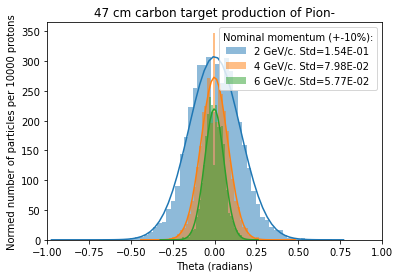

Standard deviation of: 1.55E-01 rads at 2.0 GeV/c
Standard deviation of: 8.09E-02 rads at 4.0 GeV/c
Standard deviation of: 5.90E-02 rads at 6.0 GeV/c


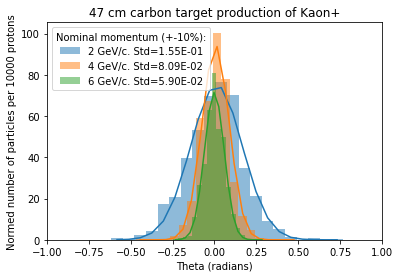

Standard deviation of: 1.53E-01 rads at 2.0 GeV/c
Standard deviation of: 9.16E-02 rads at 4.0 GeV/c
Standard deviation of: 6.39E-02 rads at 6.0 GeV/c


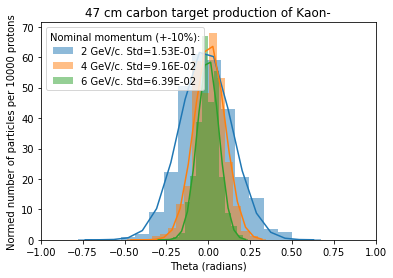

Standard deviation of: 2.33E-01 rads at 2.0 GeV/c
Standard deviation of: 1.33E-01 rads at 4.0 GeV/c
Standard deviation of: 8.25E-02 rads at 6.0 GeV/c


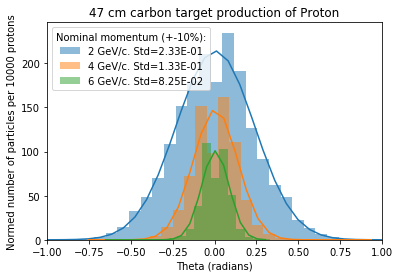

In [11]:
for particleInterested in particleList:
    
    ax = plt.gca()
    
    for nominalMomentum in nominalMomentumList:
        direction = np.asarray(PlottableData(eventList, particleInterested, nominalMomentum))
        weights =  abs(np.sin(direction)**-1) #will need to be weighted as spherical coordinate
    
        binHeight, binEnds = np.histogram(direction, weights = weights, bins = int(len(direction)**0.5))
        binCenters = (binEnds[:-1] + binEnds[1:])/2
        mean = np.mean(direction/weights)
        mu = np.std(direction/weights)**2 #variance
    
        normalisingFactor = len(direction)/np.sum(binHeight)
        weightsNormed = normalisingFactor * abs(np.sin(direction)**-1) #will need to be weighted as spherical coordinate and normed
    
        popt, pcov = curve_fit(Gauss,binCenters,binHeight,p0=[1,mean,mu]) #get optimal gaussian parameters, p0 is initial guess
        #popt has same form as p0, ie amplitude, mean, mu 
    
        color = next(ax._get_lines.prop_cycler)['color']
    
        plt.plot(binCenters, Gauss(binCenters, *popt) * normalisingFactor, '-', color = color, alpha = 1)
        plt.hist(direction, bins = int(len(direction)**0.5), weights  = weightsNormed, 
                 label = str(nominalMomentum) + ' GeV/c. Std=%2.2E' %popt[2]**0.5 , color = color, alpha = 0.5)
        plt.title(str(length) + ' cm ' + material.lower() + ' target production of ' + particleInterested.capitalize()  )
        print("Standard deviation of: %2.2E rads at %2.1f GeV/c" %(popt[2]**0.5, nominalMomentum))
    
    plt.legend(title = "Nominal momentum (+-10%):")
    plt.xlim(-1,1)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Normed number of particles per 10000 protons')
    plt.savefig(path + '\\normalised_' + particleInterested + '_' + folderName)
    plt.show()

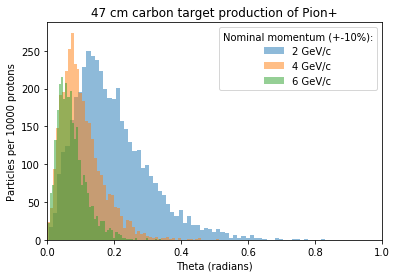

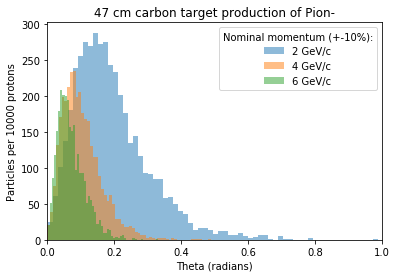

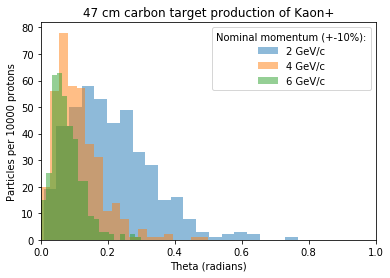

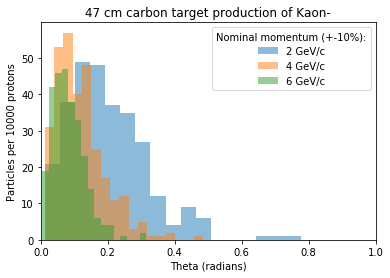

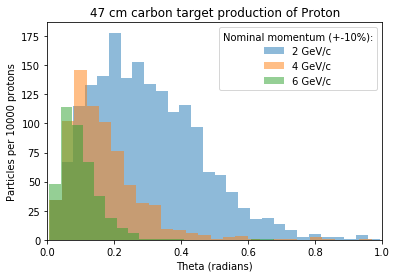

In [12]:
for particleInterested in particleList:
    
    ax = plt.gca()
    
    for nominalMomentum in nominalMomentumList:
        direction = abs(np.asarray(PlottableData(eventList, particleInterested, nominalMomentum)))    
        color = next(ax._get_lines.prop_cycler)['color']
    
        plt.hist(direction, bins = int(len(direction)**0.5), 
                 label = str(nominalMomentum) + ' GeV/c' , color = color, alpha = 0.5)
        plt.title(str(length) + ' cm ' + material.lower() + ' target production of ' + particleInterested.capitalize()  )
        
    
    plt.legend(title = "Nominal momentum (+-10%):")
    plt.xlim(0,1)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Particles per 10000 protons')
    plt.savefig(path + '\\unnormalised_' + particleInterested + '_' + folderName)
    plt.show()

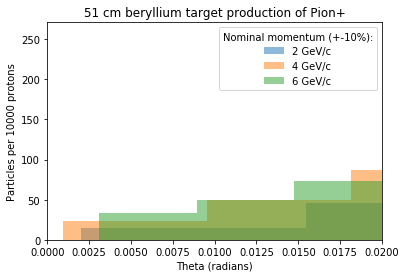

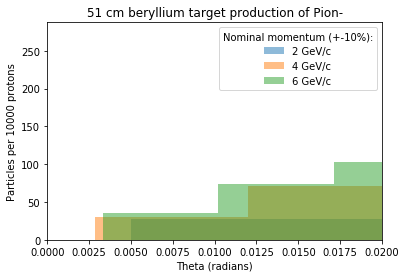

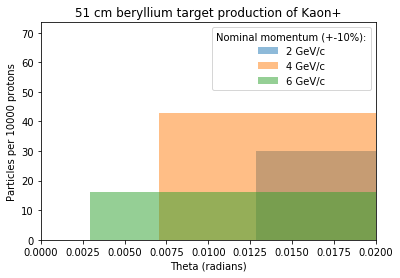

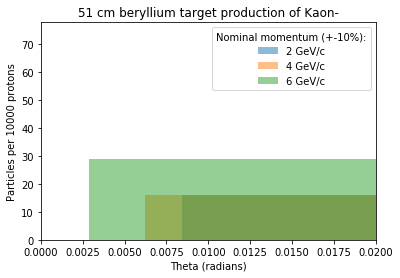

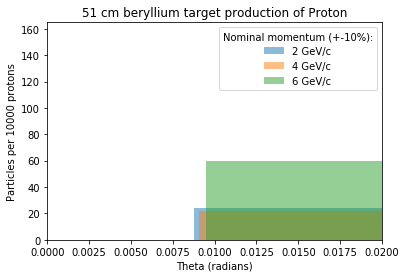

In [16]:
for particleInterested in particleList:
    
    ax = plt.gca()
    
    for nominalMomentum in nominalMomentumList:
        direction = abs(np.asarray(PlottableData(eventList, particleInterested, nominalMomentum)))    
        color = next(ax._get_lines.prop_cycler)['color']
    
        plt.hist(direction, bins = int(len(direction)**0.5), 
                 label = str(nominalMomentum) + ' GeV/c' , color = color, alpha = 0.5)
        plt.title(str(length) + ' cm ' + material.lower() + ' target production of ' + particleInterested.capitalize()  )
        
    
    plt.legend(title = "Nominal momentum (+-10%):")
    plt.xlim(0,0.02)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Particles per 10000 protons')
    plt.savefig(path + '\\unnormZoom_' + particleInterested + '_' + folderName)
    plt.show()